nome: Rafael Marinho Ferreira

email: rafamarinho87@gmail.com

github: https://github.com/rferreira13

In [220]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, recall_score

In [221]:
df = pd.read_excel("Test O_G_Equipment_Data.xlsx")

df.to_csv("data.csv", index=False)

## Major task

 - Investigate one piece of equipment in different time cycles to understand what **characteristics and parameters** of the sensors **might indicate that the equipment is on the verge of failing**.

## Task 1 

- Calculate how many times the equipment has failed.

During the FPSO’s operation, various factors can cause the machine to fail and prolong its failure state. 

We ask you to explore the available data, identify, and calculate the number of times the
equipment has failed throughout its operation.

In [222]:
fig = px.bar(df["Fail"].value_counts().reset_index(), x='Fail', y='count', text_auto='s')
fig.update_traces(textposition="outside")
fig.update_layout(
        title=dict(
            text="Count of Fail and Not Fail Events",
            x=0.5, xanchor='center',
            y=0.94, yanchor='top',
            font=dict(size=26),
            pad=dict(t=10, b=10)
        ),
        margin=dict(l=60, r=40, t=120, b=50)
    )
fig.update_yaxes(range=[0, df.shape[0]])
fig.show()

In [223]:
"{:.2%}".format(df['Fail'].mean())

'8.25%'

## Task 2

- Categorize equipment failures by setup configurations (Preset 1 and Preset 2).

- How do the variables Preset_1 and Preset_2 behave during operation? 

- What insights can we derive from these variables?

In [224]:
def failure_report(data, group):
    data_copy = data.copy()

    total = (data_copy[group].astype(str)
            .value_counts().rename_axis(group)
            .reset_index(name='Number of observations'))

    taxa = (
        data_copy[data_copy["Fail"]][group].astype(str).value_counts() 
        / data_copy[group].astype(str).value_counts()
        ).reset_index(name='Failure percentage')

    base = (total.merge(taxa, on=group, how='left')
                .fillna({'Failure percentage': 0})
                .sort_values(group))

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Bar(x=base[group], y=base['Number of observations'],
            name='Number of observations',
            text=base['Number of observations'], textposition='outside'),
        secondary_y=False
    )

    fig.add_trace(
        go.Scatter(x=base[group], y=base['Failure percentage'],
                name='Failure percentage',
                mode='lines+markers+text',
                line=dict(color='red', width=2),
                text=base['Failure percentage'],
                texttemplate='%{y:.1%}',
                textposition='top center',
                cliponaxis=False),
        secondary_y=True
    )

    fig.update_yaxes(title_text='Number of observations', secondary_y=False)
    fig.update_yaxes(title_text='Failure (%)', tickformat='.1%', secondary_y=True)
    fig.update_xaxes(title_text=group)
    fig.update_layout(
        title=dict(
            text=f"Number of observations versus Failure percentage<br><span style='font-size:16px;'>Considering {group}</span>",
            x=0.5, xanchor='center',
            y=0.94, yanchor='top',
            font=dict(size=26),
            pad=dict(t=10, b=10)
        ),
        margin=dict(l=60, r=40, t=120, b=50)
    )
    fig.show()

def heatmap_failure(data):

    data_copy = data.copy()

    matrix_data = (data_copy.groupby(['Preset_1','Preset_2'])['Fail'].mean()
        .mul(100).unstack(fill_value=0).sort_index())

    matrix_data.columns = matrix_data.columns.astype(str)
    matrix_data.index = matrix_data.index.astype(str)

    fig = px.imshow(matrix_data, text_auto='.1f', aspect='auto',
            color_continuous_scale='Reds',
            labels=dict(color='Fail %')).update_layout(
        xaxis_title='Preset_2', yaxis_title='Preset_1'
    )

    fig.update_layout(
        title=dict(
            text="Percentage Failure Heatmap<br><span style='font-size:16px;'>Combining Preset_1 and Preset_2</span>",
            x=0.5, xanchor='center',
            y=0.94, yanchor='top',
            font=dict(size=26),
            pad=dict(t=10, b=10)
        ),
        margin=dict(l=60, r=40, t=120, b=50)
    )
    
    
    fig.show()

def heatmap_configuration_changes(data, group):

    data_copy = data.copy()

    data_copy[f'Previous {group}'] = data_copy[group].shift()

    data_copy = data_copy.dropna()

    data_copy[f'Previous {group}'] = data_copy[f'Previous {group}'].astype(int)

    data_copy[f'Previous {group}'] = data_copy[f'Previous {group}'].astype(str)

    data_copy[group] = data_copy[group].astype(str)

    n_changes_df = (
        data_copy
        [[f'Previous {group}', group]]
        .value_counts()
        .reset_index(name="Number of Changes")
    )

    n_changes_df["Percent of changes during operation"] = n_changes_df["Number of Changes"] / data_copy.shape[0]

    n_changes_df = (
        n_changes_df
        .rename(columns={
            f'Previous {group}':"From",
            group:"To"
            }
        )
        .sort_values(by=["From", "To"])
        .reset_index(drop=True)
    )

    order_x = sorted(n_changes_df["From"].unique())
    order_y = sorted(n_changes_df["To"].unique())

    fig = px.density_heatmap(
        n_changes_df,
        x="From", y="To", z="Percent of changes during operation",
        histfunc="sum",
        text_auto=True,
        category_orders={"From": order_x, "To": order_y},
        labels={"From": "From", "To": "To", "Percent of changes during operation": "Percent of changes during operation"},
        color_continuous_scale="Reds"
    )

    fig.update_traces(
        meta = np.array([[(n_changes_df.loc[(n_changes_df["From"]==x) & (n_changes_df["To"]==y),
                                       "Number of Changes"].values[0]) if (n_changes_df.loc[(n_changes_df["From"]==x) & (n_changes_df["To"]==y),
                                       "Number of Changes"].values) else 0
                      for x in order_x] for y in order_y[::-1]]),
        hovertemplate = "From=%{x}<br>To=%{y}<br>Percent=%{z:.2%}<br>Number of Changes=%{meta}<extra></extra>",
        texttemplate="%{z:.2%}"
    )
    fig.update_layout(
        coloraxis_colorbar=dict(
            title="Percent of changes during operation",
            tickformat=".2%"
        )
    )

    fig.update_layout(
            title=dict(
                text=f"Percent of changes from {group} configurations during operation",
                x=0.5, xanchor='center',
                y=0.94, yanchor='top',
                font=dict(size=26),
                pad=dict(t=10, b=10)
            ),
            margin=dict(l=60, r=40, t=120, b=50)
        )
    if n_changes_df.shape[0] > 20:
        fig.update_layout(height=900)

    fig.show()

def boxplots(data, group, variable):

    data_copy = data.copy()

    model = smf.ols(f'{variable} ~ C({group})', data=data_copy).fit()
    resid = model.resid
    fitted = model.fittedvalues


    fig = st.probplot(resid, dist="norm", plot=plt)
    plt.title(f"QQ plot of residuals - {variable} ~ C({group})")
    plt.show()


    plt.scatter(fitted, resid, s=8, alpha=0.6)
    plt.axhline(0, lw=1, color='k')
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted - {variable} ~ C({group})")
    plt.show()

    fig = px.box(data_copy, x=group, y=variable)
    fig.update_layout(
        xaxis_title=group, yaxis_title=variable,
        xaxis_tickangle=45, margin=dict(t=120, b=100)
    )

    model = smf.ols(f'{variable} ~ C({group})', data=data_copy).fit()
    anova_tbl = sm.stats.anova_lm(model, typ=2)

    df1 = float(anova_tbl.loc[f'C({group})', 'df'])
    df2 = float(anova_tbl.loc['Residual', 'df'])
    Fval = float(anova_tbl.loc[f'C({group})', 'F'])
    pval = float(anova_tbl.loc[f'C({group})', 'PR(>F)'])
    ss_effect = float(anova_tbl.loc[f'C({group})', 'sum_sq'])
    ss_error  = float(anova_tbl.loc['Residual', 'sum_sq'])
    mse = ss_error / df2

    y = data_copy[variable].to_numpy(dtype=float)
    ss_total = float(((y - y.mean())**2).sum())

    eta2   = ss_effect / ss_total
    omega2 = (ss_effect - df1 * mse) / (ss_total + mse)

    k = data_copy[group].nunique()
    N = len(data_copy)


    text_ = (
        f"ANOVA (one-way) — {variable} ~ {group}<br>"
        f"F({int(df1)}, {int(df2)}) = {Fval:.2f}, p = {pval:.3g} "
        f"| η² = {eta2:.3f}, ω² = {omega2:.3f} "
        f"| k = {k}, N = {N}"
    )

    fig.add_annotation(
        xref='paper', yref='paper', x=0.0, y=1.12,
        text=text_, showarrow=False, align='left',
        bgcolor='rgba(255,255,255,0.75)', bordercolor='black', borderwidth=1,
        font=dict(size=12)
    )

    fig.show()

#### Evaluating Presets regarding Number of obsertations and Failure percentage

In [225]:
failure_report(df, "Preset_1")
failure_report(df, "Preset_2")

aux_data = df.copy()
aux_data["Preset_1_2"] = df['Preset_1'].astype(str) + df['Preset_2'].astype(str)

failure_report(aux_data, "Preset_1_2")

#### Presets Failure Percentage Heatmap

In [226]:
heatmap_failure(df)

#### Presets state changes during operation

In [227]:
heatmap_configuration_changes(df, "Preset_1")
heatmap_configuration_changes(df, "Preset_2")

aux_data = df.copy()
aux_data["Preset_1_2"] = df['Preset_1'].astype(str) + df['Preset_2'].astype(str)

heatmap_configuration_changes(aux_data, "Preset_1_2")

/tmp/ipykernel_710/388047762.py:131: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



#### Boxplots per presets during operation

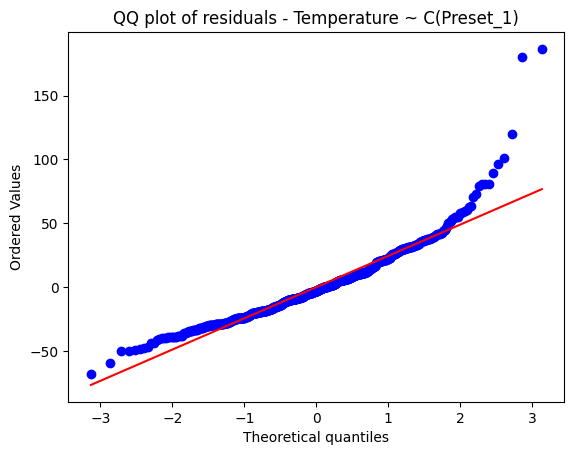

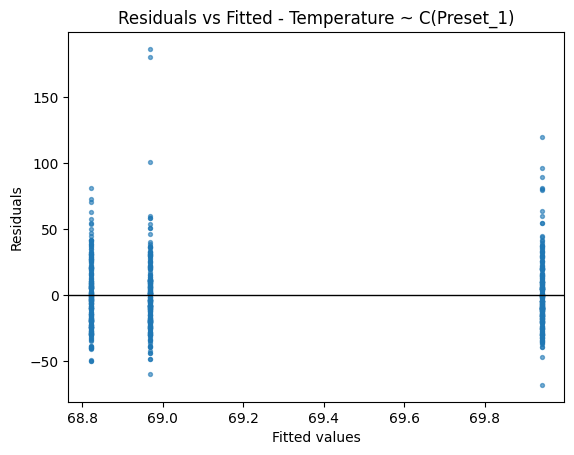

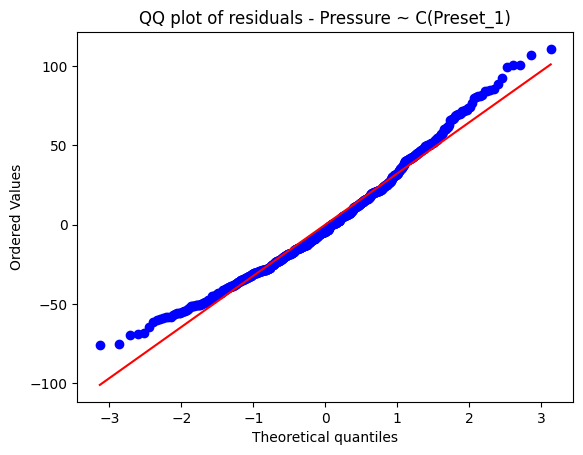

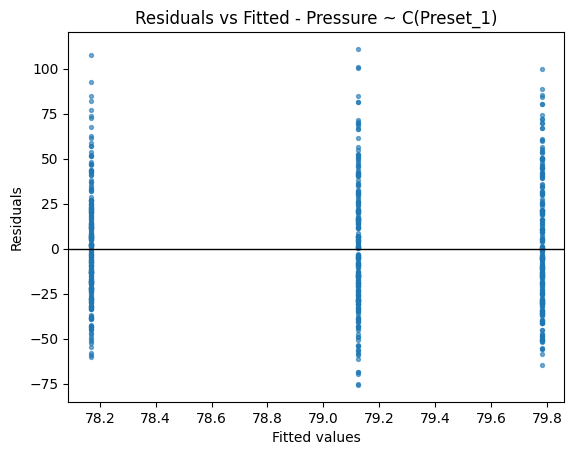

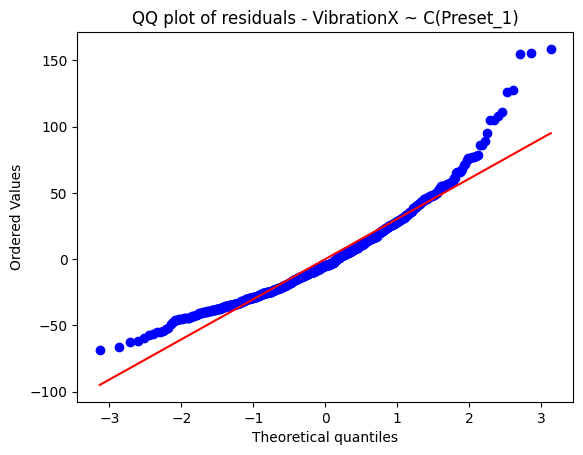

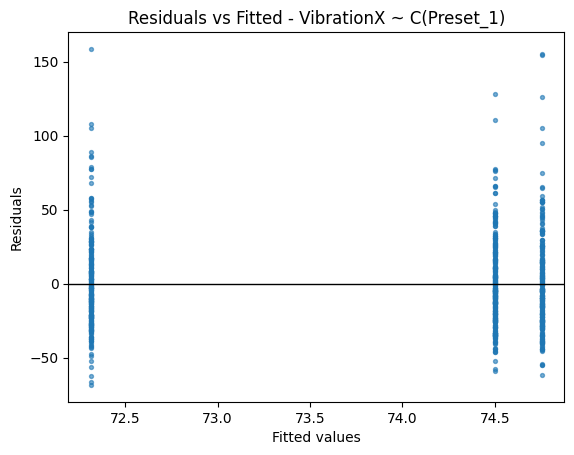

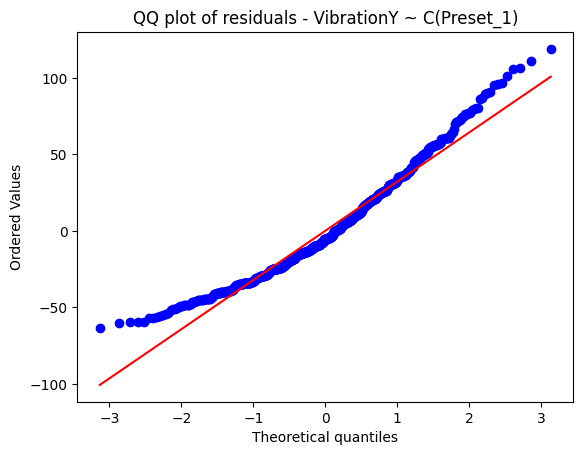

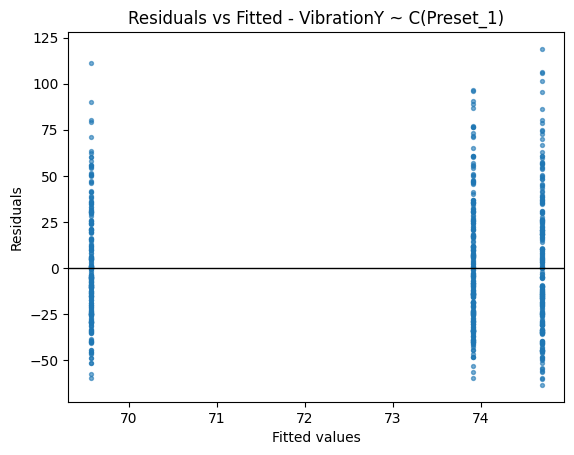

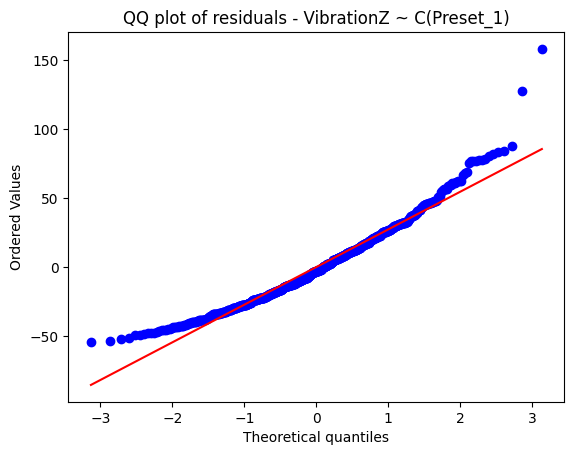

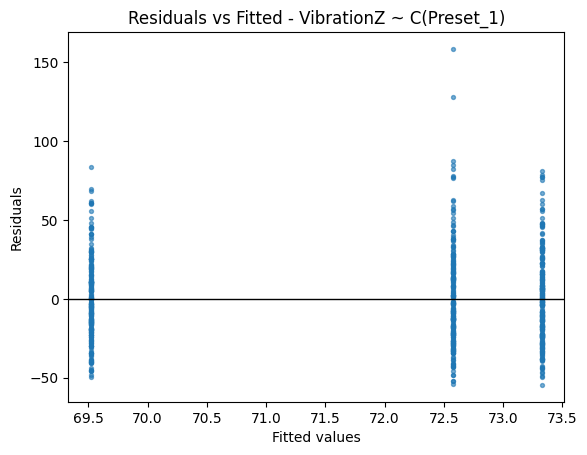

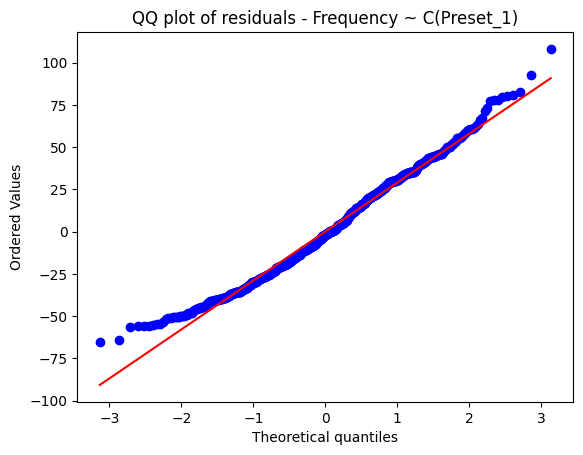

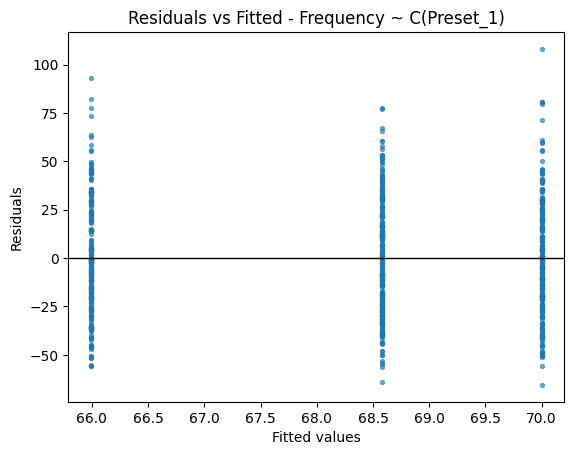

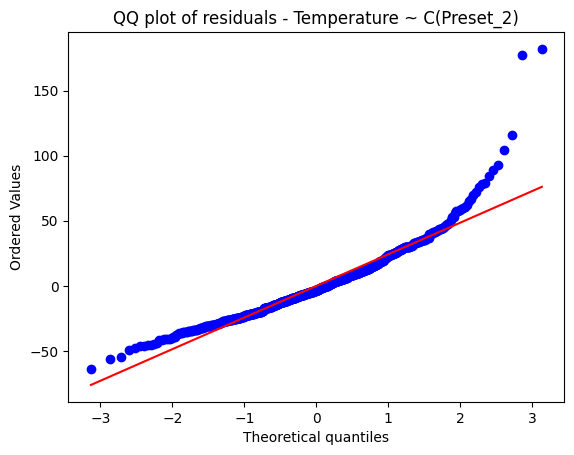

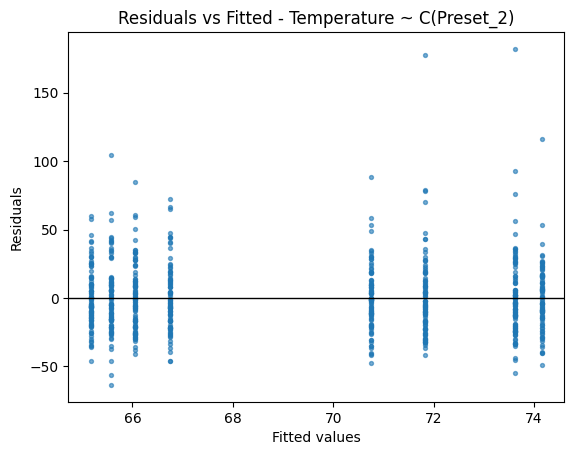

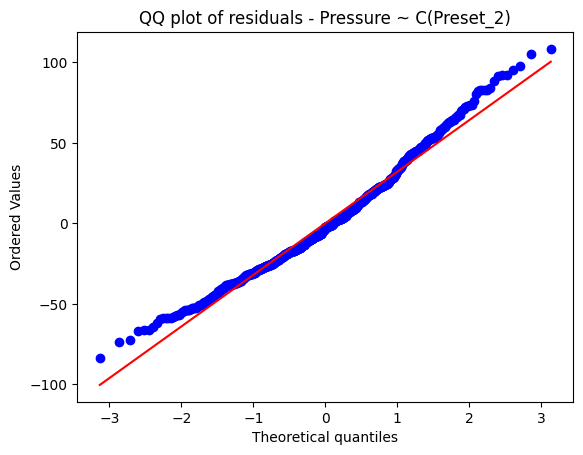

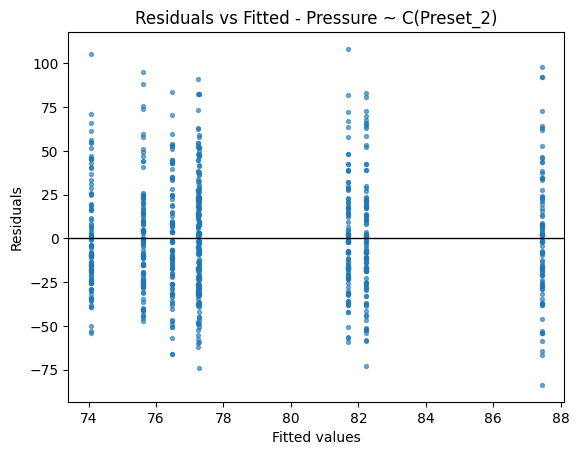

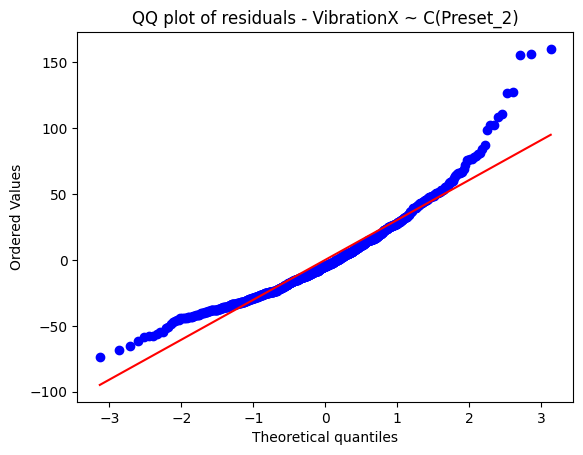

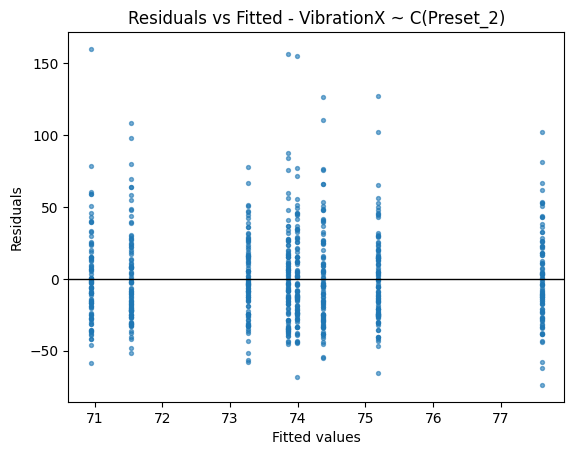

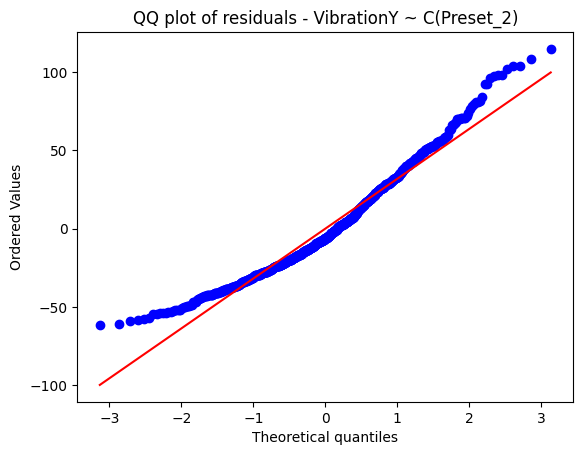

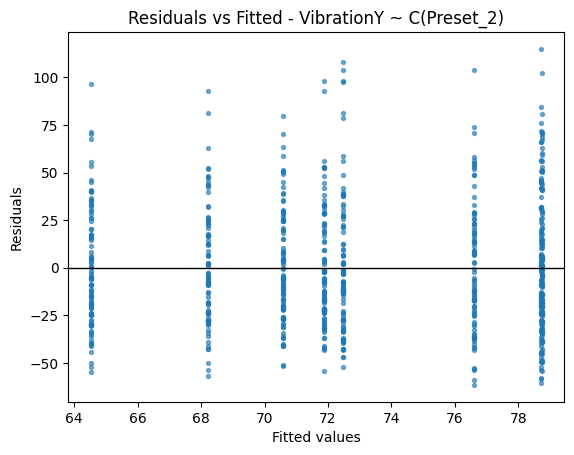

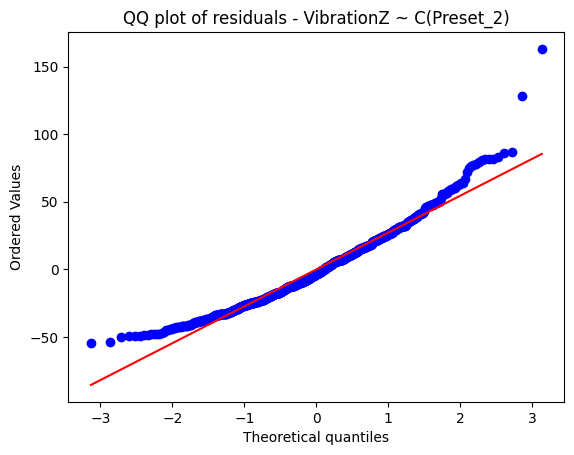

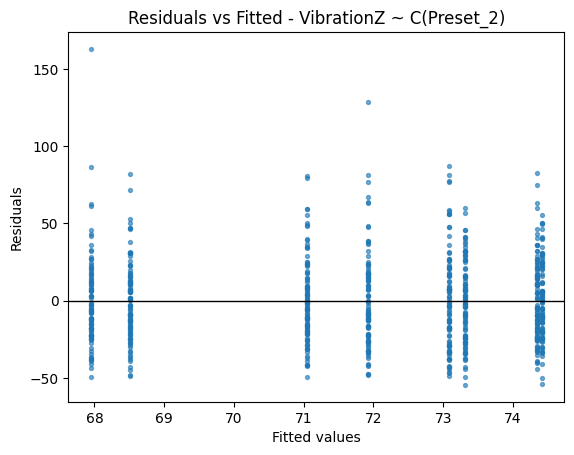

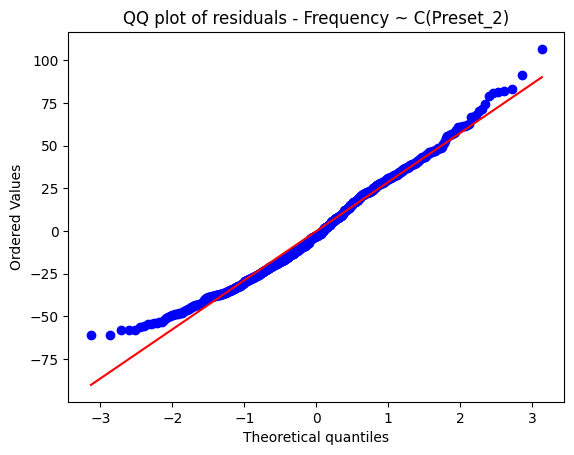

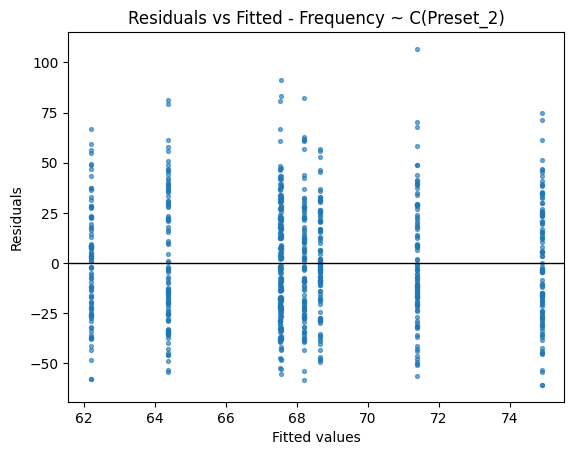

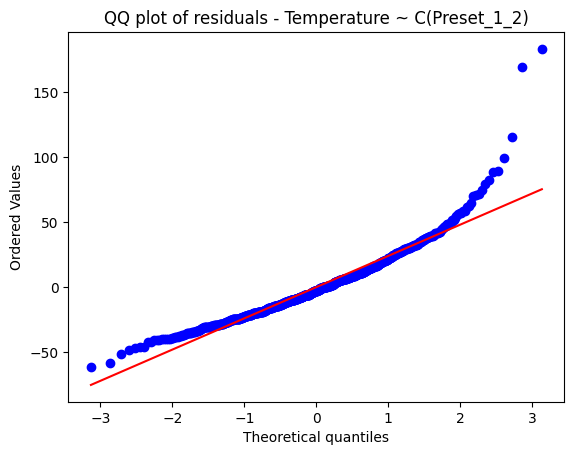

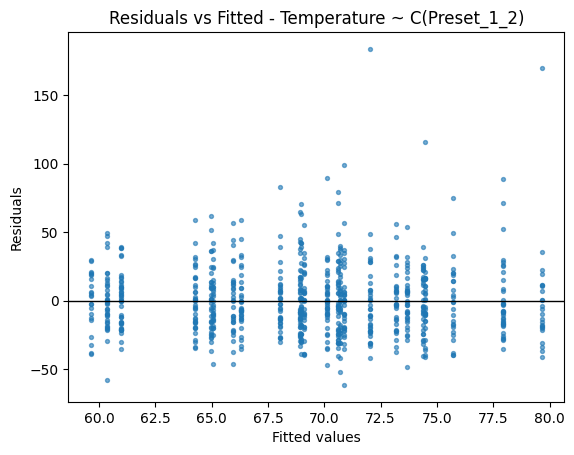

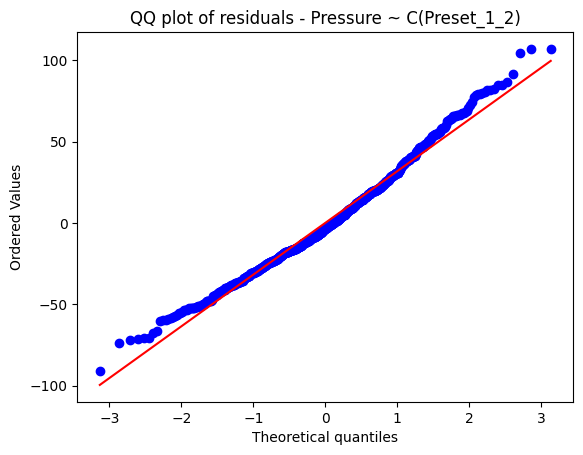

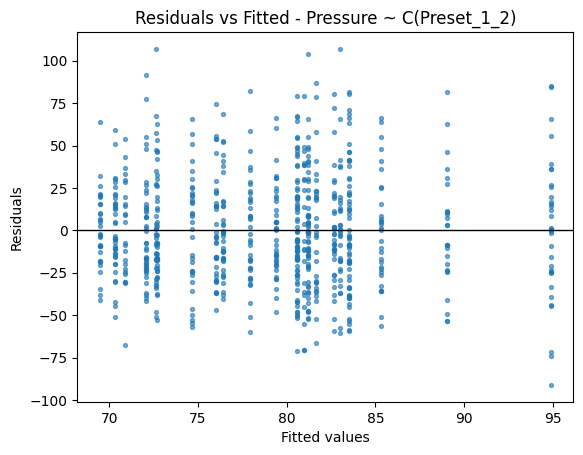

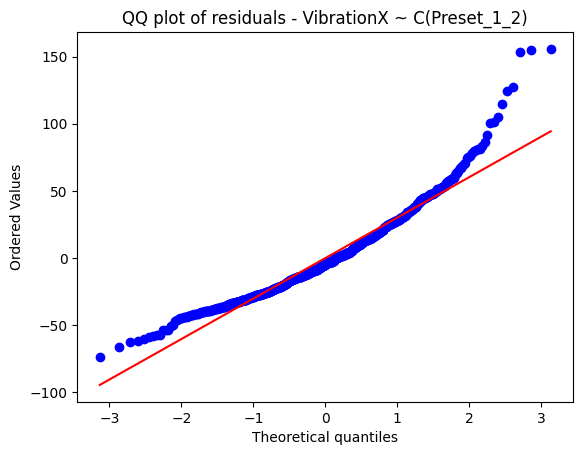

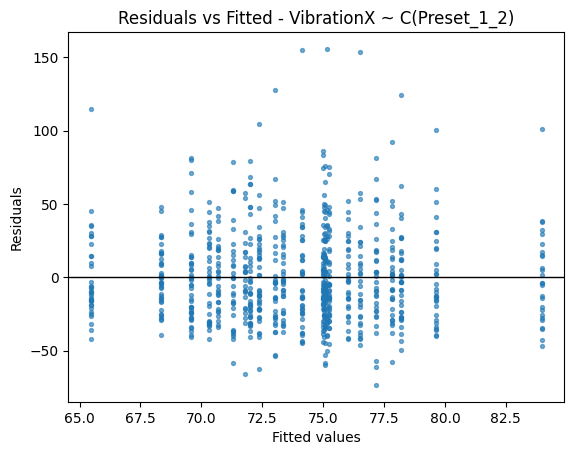

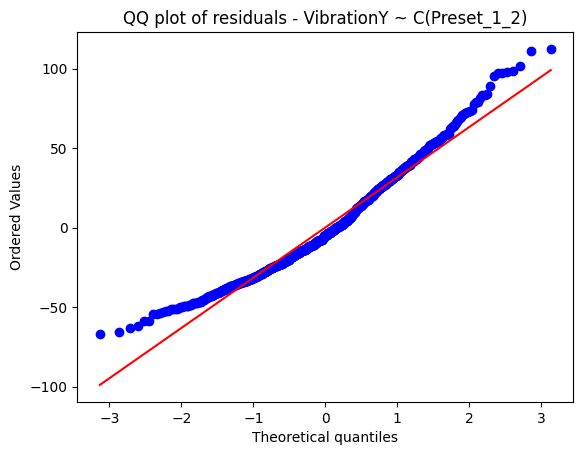

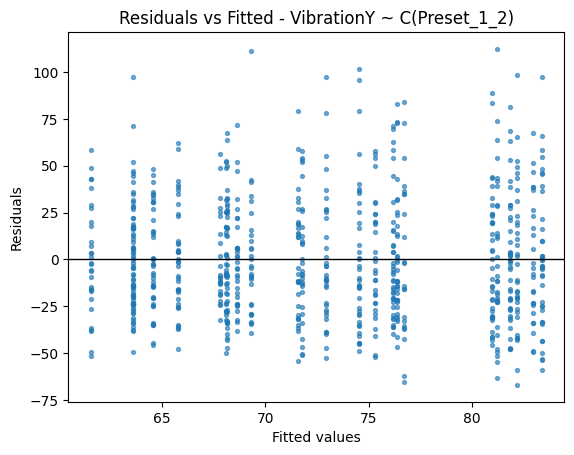

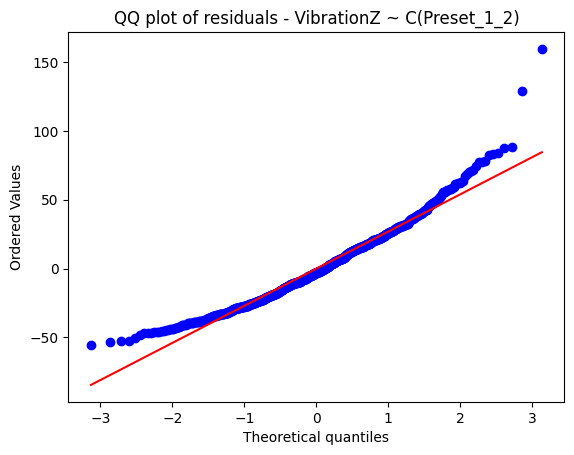

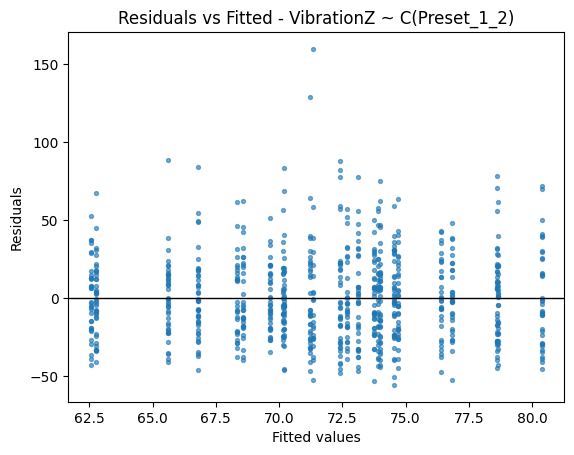

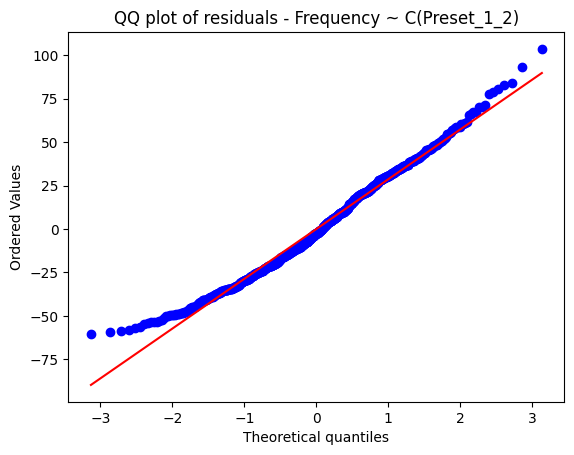

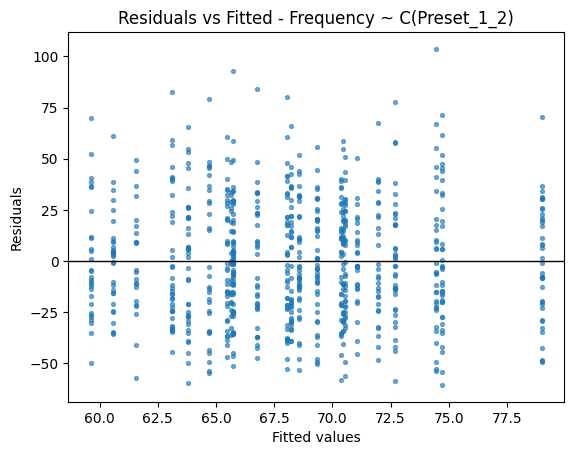

In [228]:
for column in df.columns[3:-1]:
    boxplots(df, 'Preset_1', column)

for column in df.columns[3:-1]:
    boxplots(df, 'Preset_2', column)

aux = df.copy()
aux['Preset_1_2'] = aux['Preset_1'].astype(str) + '-' + aux['Preset_2'].astype(str)
for column in df.columns[3:-1]:
    boxplots(aux, 'Preset_1_2', column)

## Task 3

- Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others).

- Analyze patterns in these readings that could indicate specific failure types. 

- How do these patterns differ across operational regimes? 

- Provide insights based on your findings.

In [229]:
def cycles_per_variable(data, x_axis, variable):

    data_copy = data.copy()

    data_copy[variable].quantile(0.95)
    data_copy[variable].quantile(0.05)

    p05 = data_copy[variable].quantile(0.05)
    p95 = data_copy[variable].quantile(0.95)
    median = data_copy[variable].median()



    fig = px.line(
        data_copy.sort_values([x_axis]),
        x=x_axis, y=variable
    )

    fig.add_trace(go.Scatter(
        x=data_copy[x_axis], y=[p95] * len(data_copy),
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ))
    fig.add_trace(go.Scatter(
        x=data_copy[x_axis], y=[p05] * len(data_copy),
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        name='P05–P95',
        opacity=0.2,
        hoverinfo='skip'
    ))
    fig.add_trace(go.Scatter(
        x=data_copy[x_axis], y=[median] * len(data_copy),
        mode='lines',
        line=dict(width=2, dash="dash", color="blue"),
        name='Median',
        hoverinfo='skip'
    ))


    fig.add_hline(y=p95, line_dash='dot', line_width=1, annotation_text='P95', annotation_position='top left')
    fig.add_hline(y=p05, line_dash='dot', line_width=1, annotation_text='P05', annotation_position='bottom left')

    # fig.add_hline(y=median, line_dash='dash', line_width=1.5, annotation_text='Median', annotation_position='top right')

    fig.data[0].update(name=variable, showlegend=True, line=dict(color="red", width=2))

    for x in data_copy.loc[data_copy["Fail"], x_axis].unique():
        fig.add_vline(x=x, line_width=2, line_color="rgba(0,0,0,0.5)")

    fig.add_scatter(x=[None], y=[None], mode="lines",
                    line=dict(color="rgba(0,0,0,0.5)", width=1),
                    name="Failure events")

    fig.update_yaxes(range=[0, 1.1 * data_copy[variable].max()])

    fig.update_layout(
        title=dict(
            text=f"{variable} per {x_axis} with Failure events",
            x=0.5, xanchor='center',
            y=0.94, yanchor='top',
            font=dict(size=26),
            pad=dict(t=10, b=10)
        ),
        margin=dict(l=60, r=40, t=120, b=50)
    )

    fig.show()

def failure_3d_plot(data, x_value, y_value, z_value):

    data_copy = data.copy()

    fig = px.scatter_3d(
        data_copy, x=x_value, y=y_value, z=z_value,
        color="Fail",
        color_discrete_map={True: "black", False: "lightgray"}
    )

    fig.update_traces(marker=dict(size=3))


    fig.update_layout(
        title=dict(
            text=f"3d Plot {x_value} versus {y_value} versus {z_value} per Failure event",
            x=0.5, xanchor='center',
            y=0.94, yanchor='top',
            font=dict(size=26),
            pad=dict(t=10, b=10)
        ),
        margin=dict(l=60, r=40, t=120, b=50)
    )
    fig.show()

def failure_2d_plot(data, x_value, y_value):

    data_copy = data.copy()

    fig = px.scatter(
            data_copy,
            x=x_value, y=y_value,
            color="Fail"
        )

    fig.update_layout(
        title=dict(
            text=f"Scatter Plot {x_value} versus {y_value} per Failure event",
            x=0.5, xanchor='center',
            y=0.94, yanchor='top',
            font=dict(size=26),
            pad=dict(t=10, b=10)
        ),
        margin=dict(l=60, r=40, t=120, b=50)
    )

    fig.show()

In [230]:
for column in df.columns[3:-1]:
    cycles_per_variable(df, "Cycle", column)

aux_data = df.copy()

aux_data["Module Vibration"] = aux_data.apply(lambda x: ((x["VibrationX"]**2) + (x["VibrationY"]**2) + (x["VibrationZ"]**2))**(1/2), axis=1)

cycles_per_variable(aux_data, "Cycle", "Module Vibration")

failure_2d_plot(df, "Temperature", "Pressure")

failure_2d_plot(aux_data, "Module Vibration", "Frequency")

failure_2d_plot(aux_data, "Module Vibration", "Temperature")

failure_2d_plot(aux_data, "Module Vibration", "Pressure")

failure_3d_plot(df, "Temperature", "Pressure", "Frequency")

failure_3d_plot(df, "VibrationX", "VibrationY", "VibrationZ")

In [231]:
def test_stationarity(series, scope):

    print(f'Dickey-Fuller (Dataset {scope}):')
    adf_test = adfuller(series.dropna())

    adf_stat = adf_test[0]
    p_value = adf_test[1]
    critical_values = adf_test[4]


    print(f'ADF statistic: {adf_stat}')
    print(f'p-value: {p_value}')
    print('Critical values:')
    for key, value in critical_values.items():
        print(f'\t{key}: {value}')


    if adf_stat < critical_values['5%']:
        print("The series is stationary (Reject the null hypothesis)")
    else:
        print("The series is NOT stationary (Fail to reject the null hypothesis)")


numerical_features = ["Temperature", "Pressure", "VibrationX", "VibrationY", "VibrationZ", "Frequency"]
for col in numerical_features:
    s = df.sort_values('Cycle')[col]
    test_stationarity(s, col)

Dickey-Fuller (Dataset Temperature):
ADF statistic: -12.988680950011224
p-value: 2.8425779537946296e-24
Critical values:
	1%: -3.438581476199162
	5%: -2.865173218890781
	10%: -2.56870466056054
The series is stationary (Reject the null hypothesis)
Dickey-Fuller (Dataset Pressure):
ADF statistic: -8.973295804703648
p-value: 7.6502921761507e-15
Critical values:
	1%: -3.438602251755426
	5%: -2.8651823762743245
	10%: -2.5687095387840673
The series is stationary (Reject the null hypothesis)
Dickey-Fuller (Dataset VibrationX):
ADF statistic: -6.9958169063199565
p-value: 7.538878106337241e-10
Critical values:
	1%: -3.438623132449471
	5%: -2.8651915799370014
	10%: -2.568714441670417
The series is stationary (Reject the null hypothesis)
Dickey-Fuller (Dataset VibrationY):
ADF statistic: -8.009749176554534
p-value: 2.2177469565403674e-12
Critical values:
	1%: -3.438602251755426
	5%: -2.8651823762743245
	10%: -2.5687095387840673
The series is stationary (Reject the null hypothesis)
Dickey-Fuller (

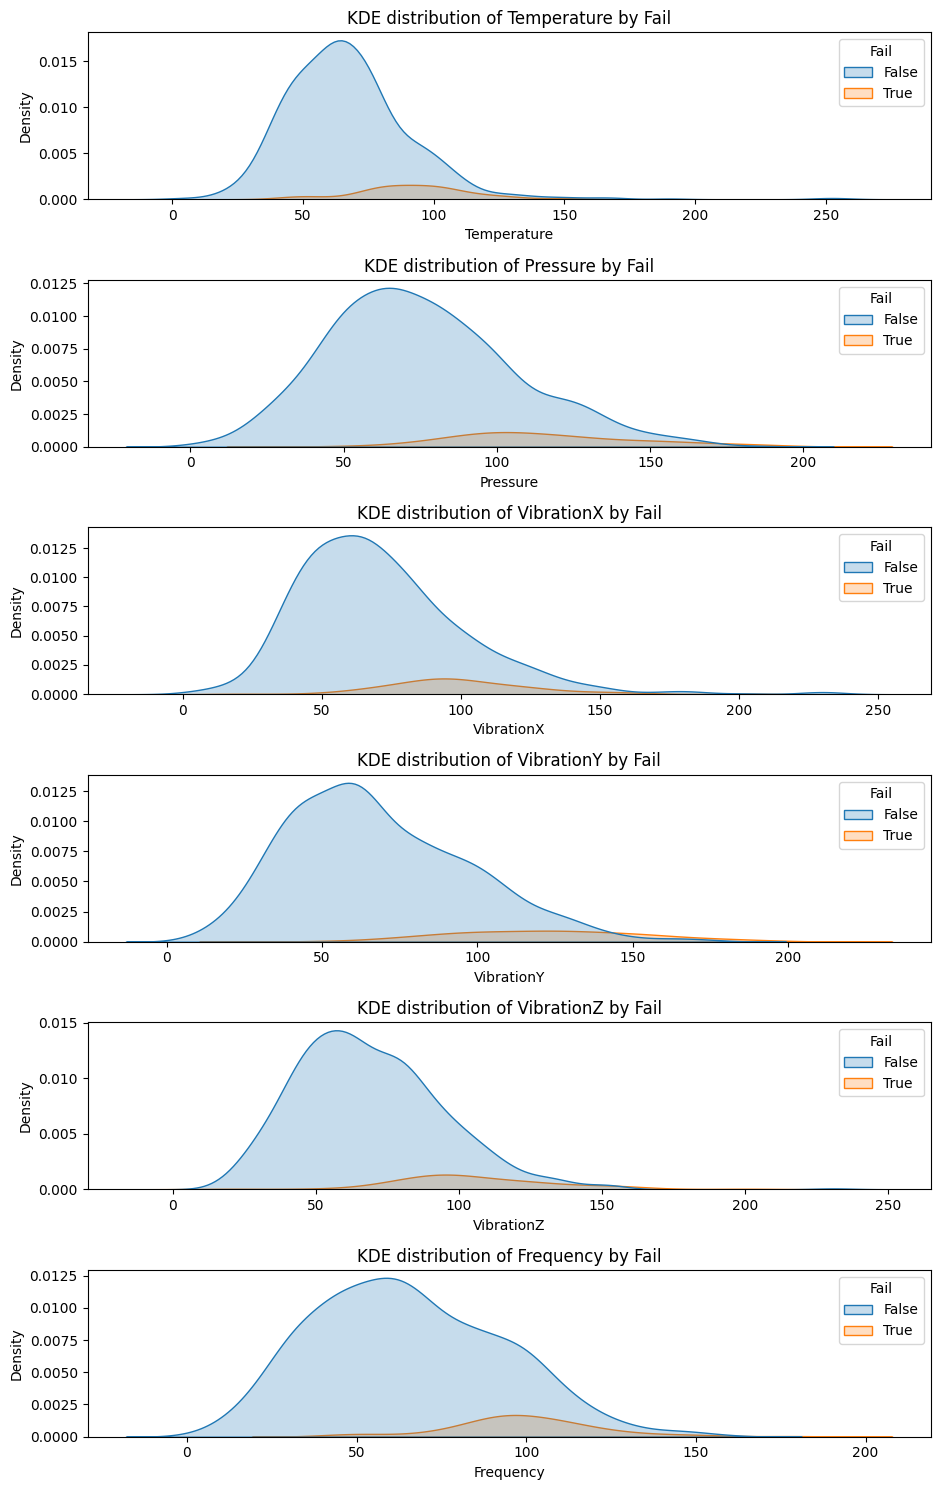

In [232]:
def kde(df, numerical_columns, target_col):

    num_cols = len(numerical_columns)
    plt.figure(figsize=(18, 15))

    for i, column in enumerate(numerical_columns):
        plt.subplot(num_cols, 2, 2*i+1)
        sns.kdeplot(data=df, x=column, hue=target_col, fill=True)
        plt.title(f'KDE distribution of {column} by {target_col}')


    plt.tight_layout()
    plt.show()

numerical_features = ["Temperature", "Pressure", "VibrationX", "VibrationY", "VibrationZ", "Frequency"]

kde(df, numerical_features, 'Fail')


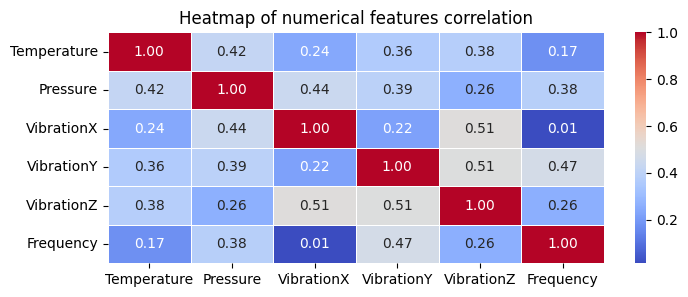

In [233]:
def plot_correlation_heatmap(df,features):
    corr_matrix = df[features].corr()

    plt.figure(figsize=(8, 3))

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

    plt.title('Heatmap of numerical features correlation')
    plt.show()

plot_correlation_heatmap(df,numerical_features)

In [234]:
def preprocess(data,drops, columns, target):
  data_copy = data.copy()
  y = data_copy[target]
  X = data_copy.drop(drops, axis=1)

  scaler = StandardScaler()
  X[columns] = scaler.fit_transform(X[columns])

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  return  X_train, X_test, y_train, y_test

def train_model(X_train, y_train, model_exp):

    scorer = make_scorer(recall_score, pos_label=1)

    if model_exp == 'Random Forest':
        model = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        }

    elif model_exp == 'SVM':
        model = SVC(kernel='rbf', random_state=42)
        param_grid = {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf']
        }

    elif model_exp == 'Logistic Regression':
        model = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1)
        param_grid = {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }

    elif model_exp == 'Extra Trees':
        model = ExtraTreesClassifier(random_state=42, n_jobs=-1)
        param_grid = {
            'n_estimators': [200, 400],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 10]
        }

    elif model_exp == 'Gradient Boosting':
        model = GradientBoostingClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 300],
            'learning_rate': [0.05, 0.1],
            'max_depth': [2, 3]
        }

    elif model_exp == 'HistGB':
        model = HistGradientBoostingClassifier(random_state=42)
        param_grid = {
            'max_depth': [None, 6, 12],
            'learning_rate': [0.05, 0.1],
            'max_leaf_nodes': [31, 63]
        }

    elif model_exp == 'KNN':
        model = KNeighborsClassifier()
        param_grid = {
            'n_neighbors': [5, 15, 30],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }

    elif model_exp == 'Linear SVM':
        model = LinearSVC(random_state=42)
        param_grid = {
            'C': [0.1, 1, 10]
        }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring=scorer, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    print(f"Better parameters for {model_exp}: {grid_search.best_params_}")
    return grid_search.best_estimator_


def predict_and_evaluate(model, X_test, y_test):

  y_pred = model.predict(X_test)
  conf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(conf_matrix, annot=True, fmt='d')
  plt.title('Confusion Matrix')
  plt.show()
  print(f'Model: {model}')
  print(classification_report(y_test, y_pred))

  f1 = f1_score(y_test, y_pred)
  print(f'F1 score: {f1 * 100:.2f}%')

In [235]:
df["Preset_1"] = df["Preset_1"].astype(str)
df["Preset_2"] = df["Preset_2"].astype(str)
df_hot = pd.get_dummies(df, columns=["Preset_1", "Preset_2"], drop_first=False)

## Task 4

- Create a model (or models) using the technique you think is most appropriate and measure its performance.

- Based on the given time-series dataset, which models or techniques are suitable for predicting whether the equipment will fail before it occurs? 

- Additionally, how can the model's performance be tuned and measured for this task?

-------------------------------------------------------------------------------
-------------------------- Original dataset -----------------------------------
Model: Random Forest
-------------------------------------------------------------------------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_s

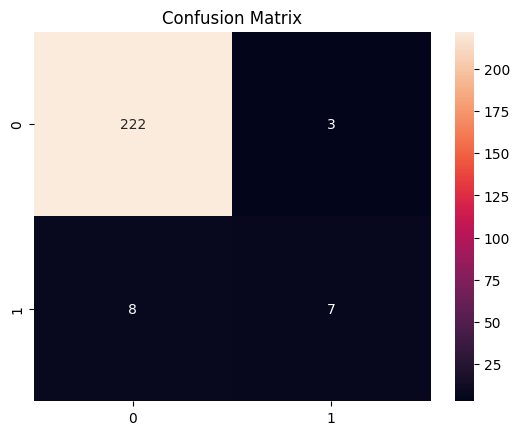

Model: RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       225
           1       0.70      0.47      0.56        15

    accuracy                           0.95       240
   macro avg       0.83      0.73      0.77       240
weighted avg       0.95      0.95      0.95       240

F1 score: 56.00%
-------------------------------------------------------------------------------
-------------------------- Random oversampled ---------------------------------
Model: Random Forest
-------------------------------------------------------------------------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END ma

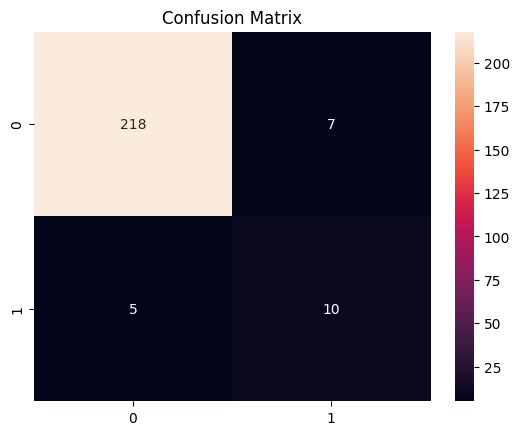

Model: RandomForestClassifier(max_depth=10, random_state=42)
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       225
           1       0.59      0.67      0.62        15

    accuracy                           0.95       240
   macro avg       0.78      0.82      0.80       240
weighted avg       0.95      0.95      0.95       240

F1 score: 62.50%
-------------------------------------------------------------------------------
-------------------------- Original dataset one hot encoded -------------------
Model: Random Forest
-------------------------------------------------------------------------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_sa

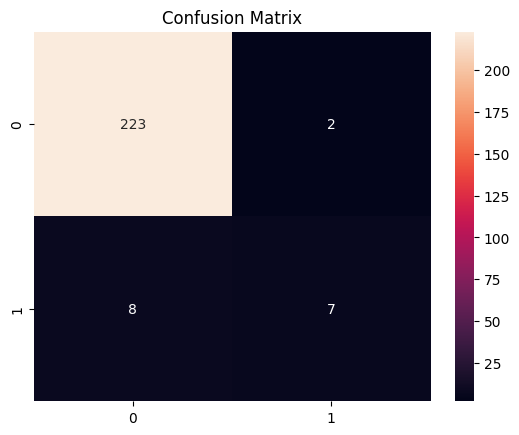

Model: RandomForestClassifier(max_depth=10, random_state=42)
              precision    recall  f1-score   support

       False       0.97      0.99      0.98       225
        True       0.78      0.47      0.58        15

    accuracy                           0.96       240
   macro avg       0.87      0.73      0.78       240
weighted avg       0.95      0.96      0.95       240

F1 score: 58.33%
-------------------------------------------------------------------------------
-------------------------- Random oversampled one hot encoded -----------------
Model: Random Forest
-------------------------------------------------------------------------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_sa

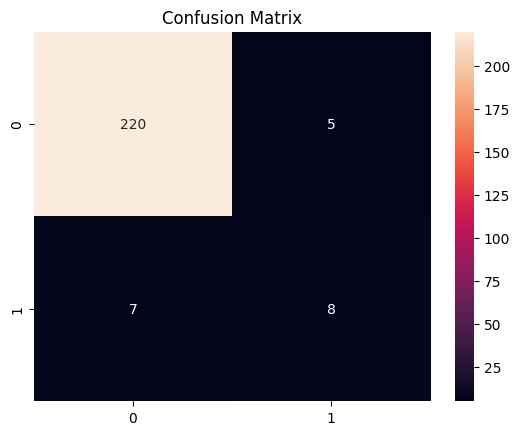

Model: RandomForestClassifier(max_depth=10, random_state=42)
              precision    recall  f1-score   support

       False       0.97      0.98      0.97       225
        True       0.62      0.53      0.57        15

    accuracy                           0.95       240
   macro avg       0.79      0.76      0.77       240
weighted avg       0.95      0.95      0.95       240

F1 score: 57.14%
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
-------------------------- Original dataset -----------------------------------
Model: SVM
-------------------------------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s

[CV] END .....................C=0.1, gamma

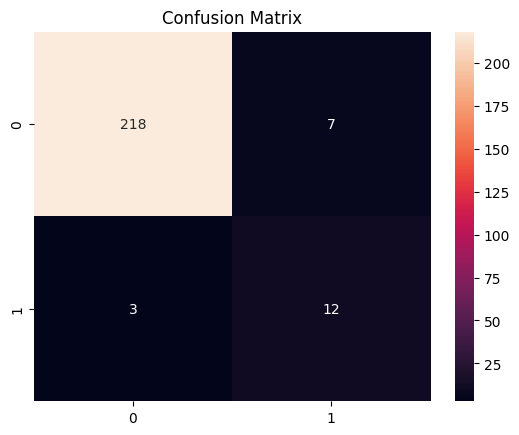

Model: SVC(C=10, random_state=42)
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       225
           1       0.63      0.80      0.71        15

    accuracy                           0.96       240
   macro avg       0.81      0.88      0.84       240
weighted avg       0.96      0.96      0.96       240

F1 score: 70.59%
-------------------------------------------------------------------------------
-------------------------- Random oversampled ---------------------------------
Model: SVM
-------------------------------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total 

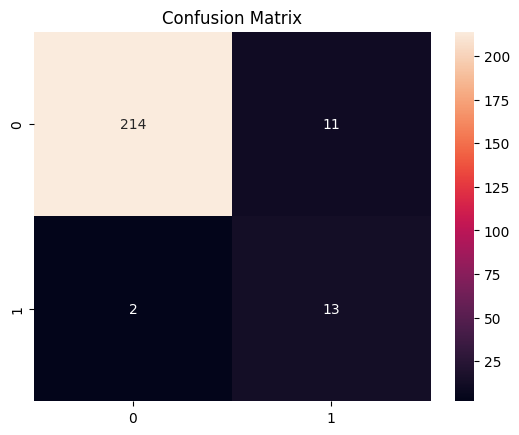

Model: SVC(C=10, random_state=42)
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       225
           1       0.54      0.87      0.67        15

    accuracy                           0.95       240
   macro avg       0.77      0.91      0.82       240
weighted avg       0.96      0.95      0.95       240

F1 score: 66.67%
-------------------------------------------------------------------------------
-------------------------- Original dataset one hot encoded -------------------
Model: SVM
-------------------------------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total 

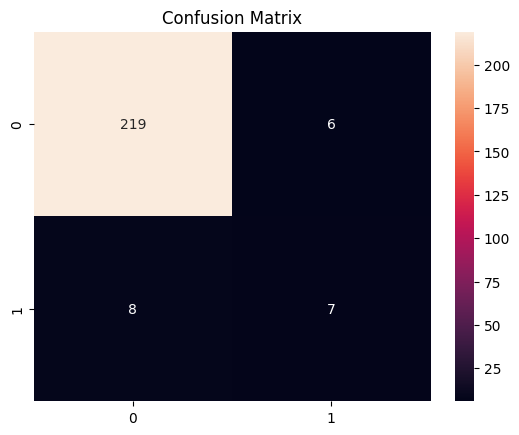

Model: SVC(C=10, random_state=42)
              precision    recall  f1-score   support

       False       0.96      0.97      0.97       225
        True       0.54      0.47      0.50        15

    accuracy                           0.94       240
   macro avg       0.75      0.72      0.73       240
weighted avg       0.94      0.94      0.94       240

F1 score: 50.00%
-------------------------------------------------------------------------------
-------------------------- Random oversampled one hot encoded -----------------
Model: SVM
-------------------------------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total 

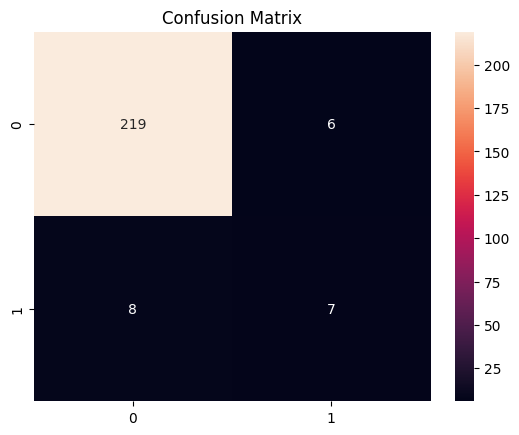

Model: SVC(C=10, random_state=42)
              precision    recall  f1-score   support

       False       0.96      0.97      0.97       225
        True       0.54      0.47      0.50        15

    accuracy                           0.94       240
   macro avg       0.75      0.72      0.73       240
weighted avg       0.94      0.94      0.94       240

F1 score: 50.00%
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
-------------------------- Original dataset -----------------------------------
Model: Logistic Regression
-------------------------------------------------------------------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s[CV] END ..................................C=0.1, pena

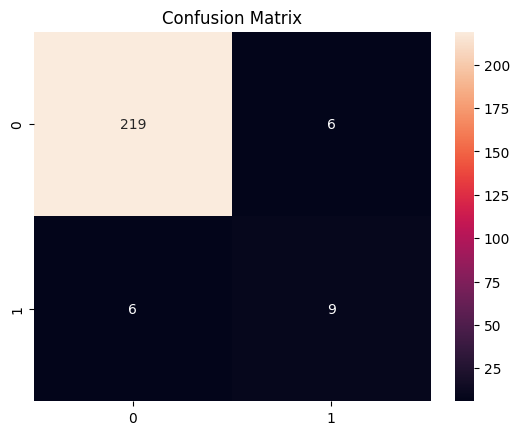

Model: LogisticRegression(C=1, max_iter=1000, n_jobs=-1, penalty='l1', solver='saga')
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       225
           1       0.60      0.60      0.60        15

    accuracy                           0.95       240
   macro avg       0.79      0.79      0.79       240
weighted avg       0.95      0.95      0.95       240

F1 score: 60.00%
-------------------------------------------------------------------------------
-------------------------- Random oversampled ---------------------------------
Model: Logistic Regression
-------------------------------------------------------------------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s


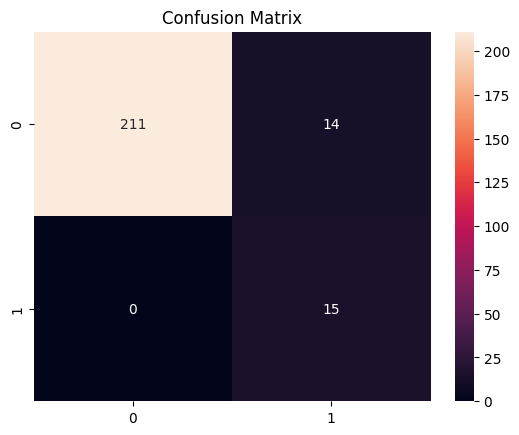

Model: LogisticRegression(C=0.1, max_iter=1000, n_jobs=-1, solver='saga')
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       225
           1       0.52      1.00      0.68        15

    accuracy                           0.94       240
   macro avg       0.76      0.97      0.82       240
weighted avg       0.97      0.94      0.95       240

F1 score: 68.18%
-------------------------------------------------------------------------------
-------------------------- Original dataset one hot encoded -------------------
Model: Logistic Regression
-------------------------------------------------------------------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END ...

/opt/ds_test_docs_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/ds_test_docs_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/ds_test_docs_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/ds_test_docs_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/ds_test_docs_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/ds_test_docs_env/lib/python3.10/site-packages/sklearn/linear_mode

[CV] END ...................................C=10, penalty=l2; total time=   0.1s
[CV] END ...................................C=10, penalty=l2; total time=   0.1s
Better parameters for Logistic Regression: {'C': 10, 'penalty': 'l1'}


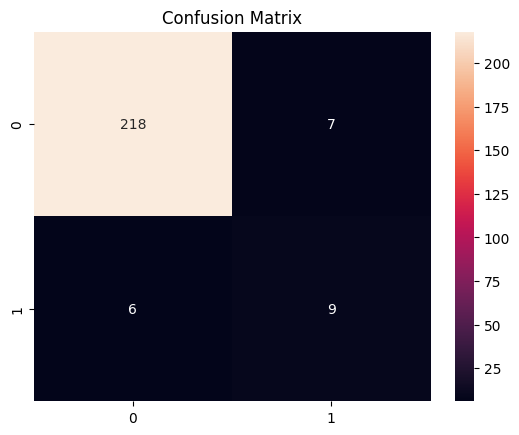

Model: LogisticRegression(C=10, max_iter=1000, n_jobs=-1, penalty='l1', solver='saga')
              precision    recall  f1-score   support

       False       0.97      0.97      0.97       225
        True       0.56      0.60      0.58        15

    accuracy                           0.95       240
   macro avg       0.77      0.78      0.78       240
weighted avg       0.95      0.95      0.95       240

F1 score: 58.06%
-------------------------------------------------------------------------------
-------------------------- Random oversampled one hot encoded -----------------
Model: Logistic Regression
-------------------------------------------------------------------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s

/opt/ds_test_docs_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/ds_test_docs_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/ds_test_docs_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/ds_test_docs_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/ds_test_docs_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/ds_test_docs_env/lib/python3.10/site-packages/sklearn/linear_mode

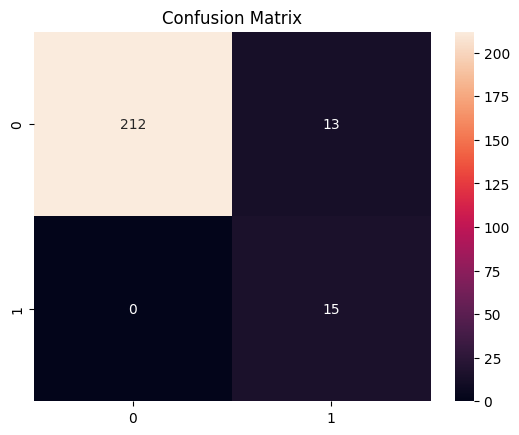

Model: LogisticRegression(C=0.1, max_iter=1000, n_jobs=-1, solver='saga')
              precision    recall  f1-score   support

       False       1.00      0.94      0.97       225
        True       0.54      1.00      0.70        15

    accuracy                           0.95       240
   macro avg       0.77      0.97      0.83       240
weighted avg       0.97      0.95      0.95       240

F1 score: 69.77%
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
-------------------------- Original dataset -----------------------------------
Model: Extra Trees
-------------------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_de

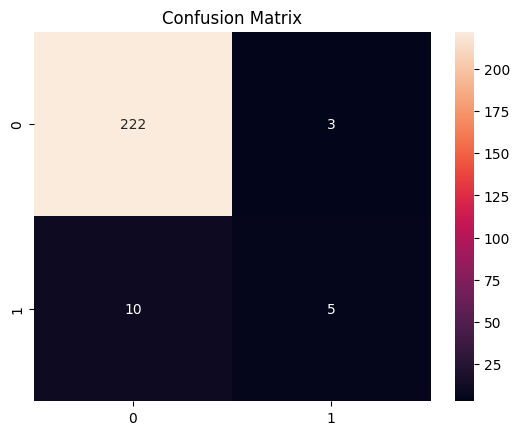

Model: ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       225
           1       0.62      0.33      0.43        15

    accuracy                           0.95       240
   macro avg       0.79      0.66      0.70       240
weighted avg       0.94      0.95      0.94       240

F1 score: 43.48%
-------------------------------------------------------------------------------
-------------------------- Random oversampled ---------------------------------
Model: Extra Trees
-------------------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END ma

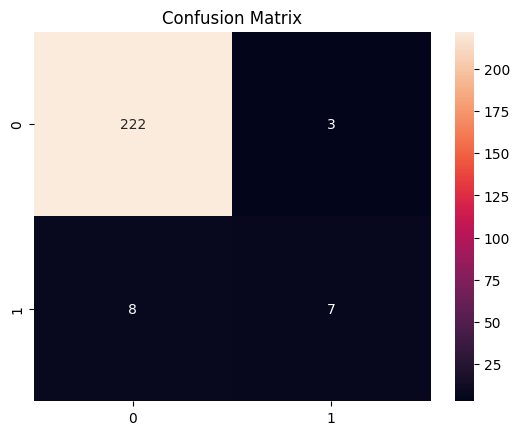

Model: ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       225
           1       0.70      0.47      0.56        15

    accuracy                           0.95       240
   macro avg       0.83      0.73      0.77       240
weighted avg       0.95      0.95      0.95       240

F1 score: 56.00%
-------------------------------------------------------------------------------
-------------------------- Original dataset one hot encoded -------------------
Model: Extra Trees
-------------------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END ma

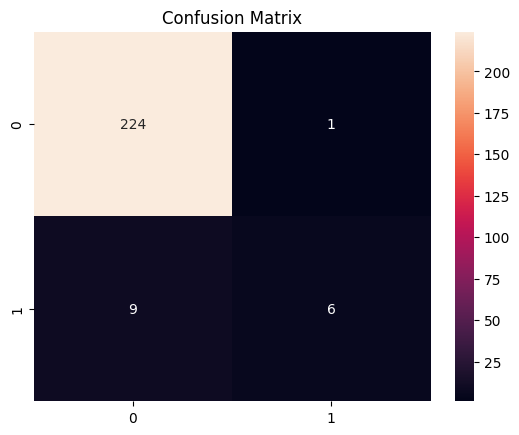

Model: ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

       False       0.96      1.00      0.98       225
        True       0.86      0.40      0.55        15

    accuracy                           0.96       240
   macro avg       0.91      0.70      0.76       240
weighted avg       0.95      0.96      0.95       240

F1 score: 54.55%
-------------------------------------------------------------------------------
-------------------------- Random oversampled one hot encoded -----------------
Model: Extra Trees
-------------------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_

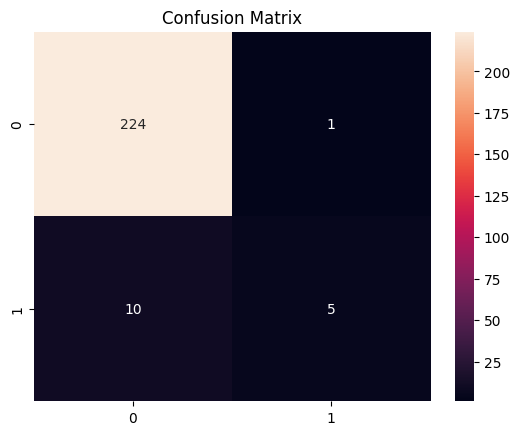

Model: ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

       False       0.96      1.00      0.98       225
        True       0.83      0.33      0.48        15

    accuracy                           0.95       240
   macro avg       0.90      0.66      0.73       240
weighted avg       0.95      0.95      0.94       240

F1 score: 47.62%
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
-------------------------- Original dataset -----------------------------------
Model: Gradient Boosting
-------------------------------------------------------------------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.1s
[CV] END ..lear

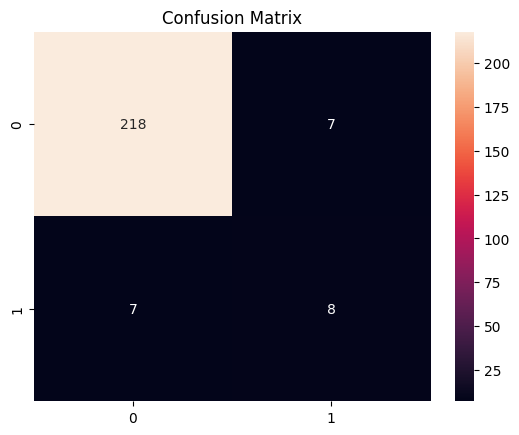

Model: GradientBoostingClassifier(learning_rate=0.05, max_depth=2, n_estimators=300,
                           random_state=42)
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       225
           1       0.53      0.53      0.53        15

    accuracy                           0.94       240
   macro avg       0.75      0.75      0.75       240
weighted avg       0.94      0.94      0.94       240

F1 score: 53.33%
-------------------------------------------------------------------------------
-------------------------- Random oversampled ---------------------------------
Model: Gradient Boosting
-------------------------------------------------------------------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth

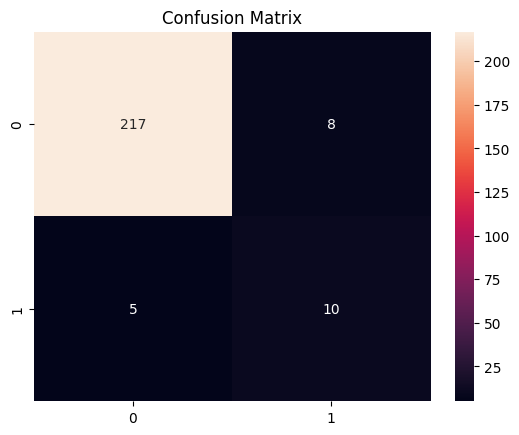

Model: GradientBoostingClassifier(learning_rate=0.05, max_depth=2, n_estimators=300,
                           random_state=42)
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       225
           1       0.56      0.67      0.61        15

    accuracy                           0.95       240
   macro avg       0.77      0.82      0.79       240
weighted avg       0.95      0.95      0.95       240

F1 score: 60.61%
-------------------------------------------------------------------------------
-------------------------- Original dataset one hot encoded -------------------
Model: Gradient Boosting
-------------------------------------------------------------------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth

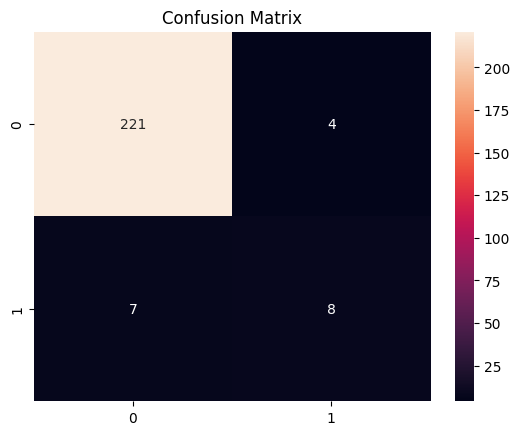

Model: GradientBoostingClassifier(n_estimators=300, random_state=42)
              precision    recall  f1-score   support

       False       0.97      0.98      0.98       225
        True       0.67      0.53      0.59        15

    accuracy                           0.95       240
   macro avg       0.82      0.76      0.78       240
weighted avg       0.95      0.95      0.95       240

F1 score: 59.26%
-------------------------------------------------------------------------------
-------------------------- Random oversampled one hot encoded -----------------
Model: Gradient Boosting
-------------------------------------------------------------------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END ..learning

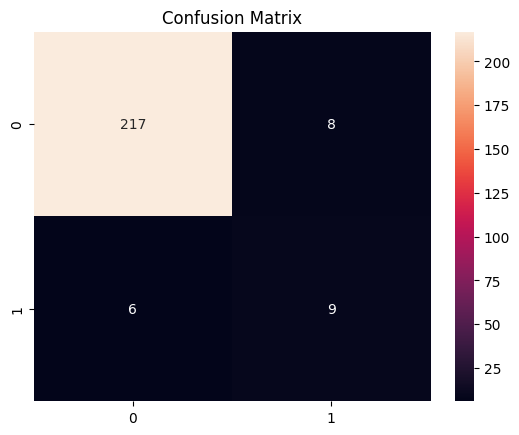

Model: GradientBoostingClassifier(learning_rate=0.05, max_depth=2, n_estimators=300,
                           random_state=42)
              precision    recall  f1-score   support

       False       0.97      0.96      0.97       225
        True       0.53      0.60      0.56        15

    accuracy                           0.94       240
   macro avg       0.75      0.78      0.77       240
weighted avg       0.95      0.94      0.94       240

F1 score: 56.25%
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
-------------------------- Original dataset -----------------------------------
Model: HistGB
-------------------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END learning_rate=0.05, max_depth=None, max_leaf_nodes=31; total time=   0.1s
[CV] END .learning_rate=0.05, max_depth=6, max_le

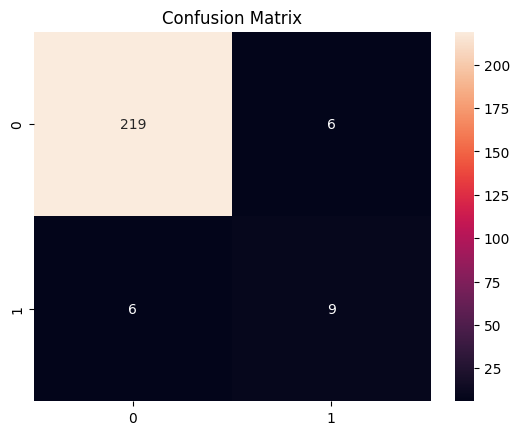

Model: HistGradientBoostingClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       225
           1       0.60      0.60      0.60        15

    accuracy                           0.95       240
   macro avg       0.79      0.79      0.79       240
weighted avg       0.95      0.95      0.95       240

F1 score: 60.00%
-------------------------------------------------------------------------------
-------------------------- Random oversampled ---------------------------------
Model: HistGB
-------------------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .learning_rate=0.05, max_depth=6, max_leaf_nodes=31; total time=   0.1s
[CV] END .learning_rate=0.05, max_depth=6, max_leaf_nodes=31; total time=   0.1s
[CV] END .learning_rate=0.05, max_depth=6, max_leaf_nodes=31; total time=   0.1s
[CV] END .learning_rate=0.05, max_depth=6, 

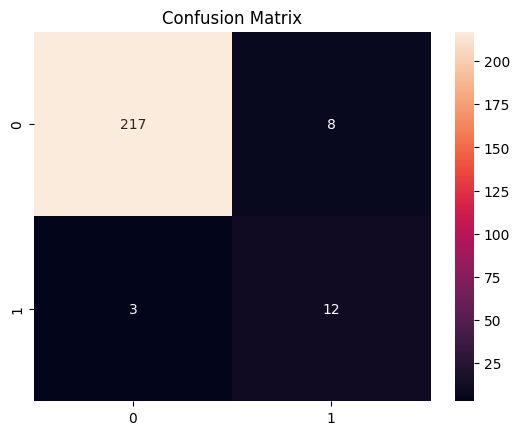

Model: HistGradientBoostingClassifier(learning_rate=0.05, random_state=42)
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       225
           1       0.60      0.80      0.69        15

    accuracy                           0.95       240
   macro avg       0.79      0.88      0.83       240
weighted avg       0.96      0.95      0.96       240

F1 score: 68.57%
-------------------------------------------------------------------------------
-------------------------- Original dataset one hot encoded -------------------
Model: HistGB
-------------------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .learning_rate=0.05, max_depth=6, max_leaf_nodes=31; total time=   0.1s
[CV] END .learning_rate=0.05, max_depth=6, max_leaf_nodes=31; total time=   0.1s
[CV] END .learning_rate=0.05, max_depth=6, max_leaf_nodes=31; total time=   0.1s
[CV] END learning_rate=

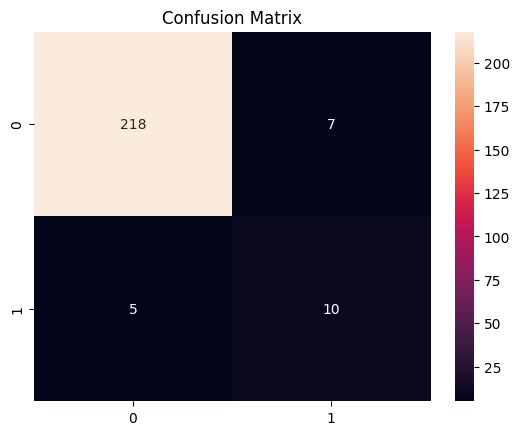

Model: HistGradientBoostingClassifier(random_state=42)
              precision    recall  f1-score   support

       False       0.98      0.97      0.97       225
        True       0.59      0.67      0.62        15

    accuracy                           0.95       240
   macro avg       0.78      0.82      0.80       240
weighted avg       0.95      0.95      0.95       240

F1 score: 62.50%
-------------------------------------------------------------------------------
-------------------------- Random oversampled one hot encoded -----------------
Model: HistGB
-------------------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .learning_rate=0.05, max_depth=6, max_leaf_nodes=31; total time=   0.1s
[CV] END .learning_rate=0.05, max_depth=6, max_leaf_nodes=31; total time=   0.2s
[CV] END .learning_rate=0.05, max_depth=6, max_leaf_nodes=63; total time=   0.2s
[CV] END .learning_rate=0.05, max_depth=6, 

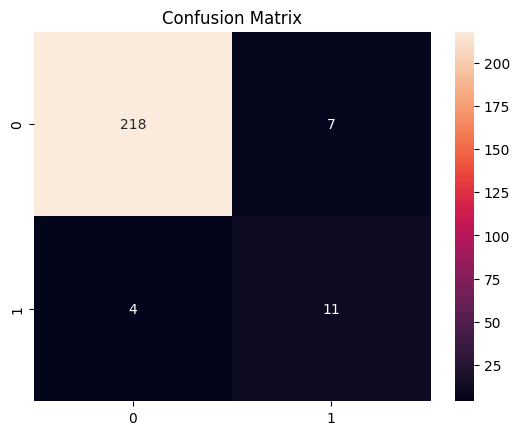

Model: HistGradientBoostingClassifier(learning_rate=0.05, random_state=42)
              precision    recall  f1-score   support

       False       0.98      0.97      0.98       225
        True       0.61      0.73      0.67        15

    accuracy                           0.95       240
   macro avg       0.80      0.85      0.82       240
weighted avg       0.96      0.95      0.96       240

F1 score: 66.67%
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
-------------------------- Original dataset -----------------------------------
Model: KNN
-------------------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END ...............n_n

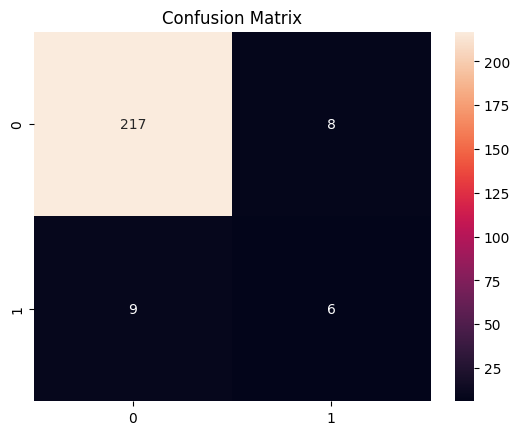

Model: KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       225
           1       0.43      0.40      0.41        15

    accuracy                           0.93       240
   macro avg       0.69      0.68      0.69       240
weighted avg       0.93      0.93      0.93       240

F1 score: 41.38%
-------------------------------------------------------------------------------
-------------------------- Random oversampled ---------------------------------
Model: KNN
-------------------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total tim

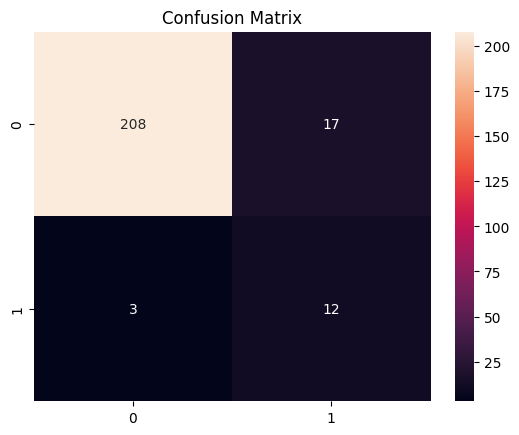

Model: KNeighborsClassifier(p=1, weights='distance')
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       225
           1       0.41      0.80      0.55        15

    accuracy                           0.92       240
   macro avg       0.70      0.86      0.75       240
weighted avg       0.95      0.92      0.93       240

F1 score: 54.55%
-------------------------------------------------------------------------------
-------------------------- Original dataset one hot encoded -------------------
Model: KNN
-------------------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   0.1s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   0.1s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   0.1s
[CV] END ...............n_neighbors=5, p=1, weig

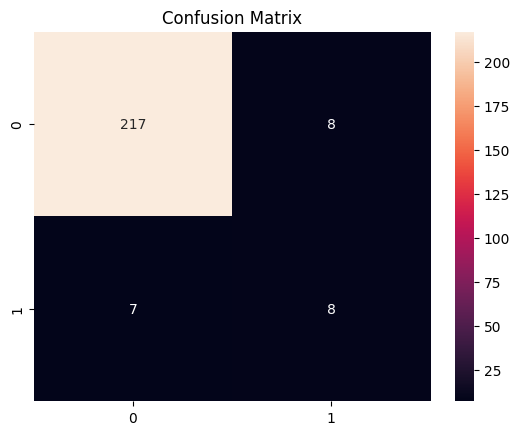

Model: KNeighborsClassifier()
              precision    recall  f1-score   support

       False       0.97      0.96      0.97       225
        True       0.50      0.53      0.52        15

    accuracy                           0.94       240
   macro avg       0.73      0.75      0.74       240
weighted avg       0.94      0.94      0.94       240

F1 score: 51.61%
-------------------------------------------------------------------------------
-------------------------- Random oversampled one hot encoded -----------------
Model: KNN
-------------------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total tim

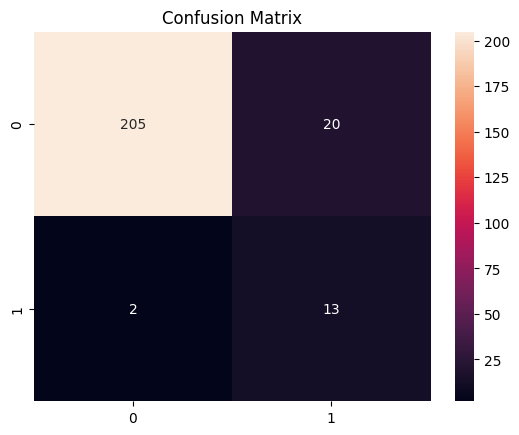

Model: KNeighborsClassifier(weights='distance')
              precision    recall  f1-score   support

       False       0.99      0.91      0.95       225
        True       0.39      0.87      0.54        15

    accuracy                           0.91       240
   macro avg       0.69      0.89      0.75       240
weighted avg       0.95      0.91      0.92       240

F1 score: 54.17%
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
-------------------------- Original dataset -----------------------------------
Model: Linear SVM
-------------------------------------------------------------------------------
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................................................C=1; total time=   0.0s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END .......................................

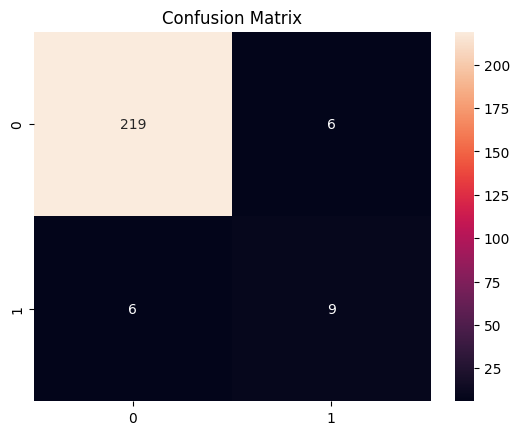

Model: LinearSVC(C=10, random_state=42)
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       225
           1       0.60      0.60      0.60        15

    accuracy                           0.95       240
   macro avg       0.79      0.79      0.79       240
weighted avg       0.95      0.95      0.95       240

F1 score: 60.00%
-------------------------------------------------------------------------------
-------------------------- Random oversampled ---------------------------------
Model: Linear SVM
-------------------------------------------------------------------------------
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................

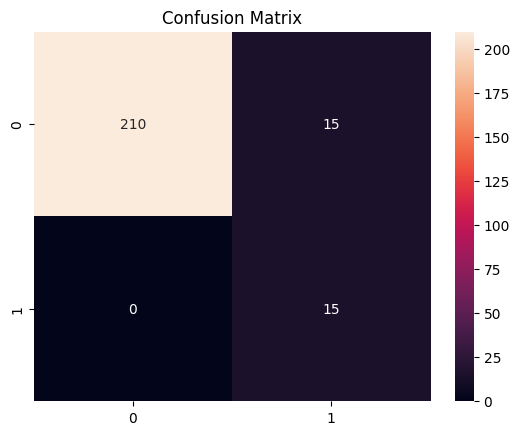

Model: LinearSVC(C=0.1, random_state=42)
              precision    recall  f1-score   support

           0       1.00      0.93      0.97       225
           1       0.50      1.00      0.67        15

    accuracy                           0.94       240
   macro avg       0.75      0.97      0.82       240
weighted avg       0.97      0.94      0.95       240

F1 score: 66.67%
-------------------------------------------------------------------------------
-------------------------- Original dataset one hot encoded -------------------
Model: Linear SVM
-------------------------------------------------------------------------------
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END .............................................

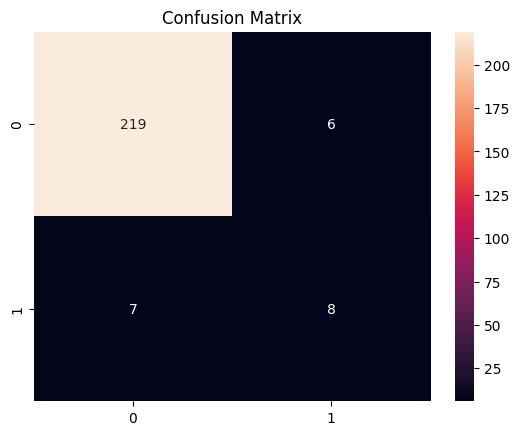

Model: LinearSVC(C=1, random_state=42)
              precision    recall  f1-score   support

       False       0.97      0.97      0.97       225
        True       0.57      0.53      0.55        15

    accuracy                           0.95       240
   macro avg       0.77      0.75      0.76       240
weighted avg       0.94      0.95      0.94       240

F1 score: 55.17%
-------------------------------------------------------------------------------
-------------------------- Random oversampled one hot encoded -----------------
Model: Linear SVM
-------------------------------------------------------------------------------
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ...............................................

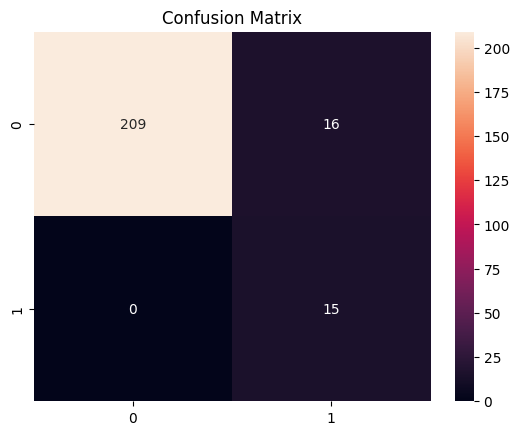

Model: LinearSVC(C=0.1, random_state=42)
              precision    recall  f1-score   support

       False       1.00      0.93      0.96       225
        True       0.48      1.00      0.65        15

    accuracy                           0.93       240
   macro avg       0.74      0.96      0.81       240
weighted avg       0.97      0.93      0.94       240

F1 score: 65.22%
-------------------------------------------------------------------------------


In [236]:
models = ['Random Forest', 'SVM', 'Logistic Regression', 'Extra Trees', 'Gradient Boosting', 'HistGB', 'KNN', 'Linear SVM']
aux = df.copy()
aux["Fail"] = aux["Fail"].apply(lambda x: 1 if x else 0)
drops = ["Preset_1",  "Preset_2", "Fail", "Cycle"]
X_train, X_test, y_train, y_test = preprocess(aux, drops, numerical_features, "Fail")
ros = RandomOverSampler(sampling_strategy=0.5, random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
X_train_hot, X_test_hot, y_train_hot, y_test_hot = preprocess(df_hot, ["Fail", "Cycle"], numerical_features, "Fail")
X_train_hot_ros, y_train_hot_ros = ros.fit_resample(X_train_hot, y_train_hot)

for model in models:
  print('-------------------------------------------------------------------------------')
  print('-------------------------- Original dataset -----------------------------------')
  print(f'Model: {model}')
  print('-------------------------------------------------------------------------------')
  tmodel = train_model(X_train, y_train, model)
  predict_and_evaluate(tmodel, X_test, y_test)
  print('-------------------------------------------------------------------------------')
  print('-------------------------- Random oversampled ---------------------------------')
  print(f'Model: {model}')
  print('-------------------------------------------------------------------------------')
  tmodel = train_model(X_train_ros, y_train_ros, model)
  predict_and_evaluate(tmodel, X_test, y_test)
  print('-------------------------------------------------------------------------------')
  print('-------------------------- Original dataset one hot encoded -------------------')
  print(f'Model: {model}')
  print('-------------------------------------------------------------------------------')
  tmodel = train_model(X_train_hot, y_train_hot, model)
  predict_and_evaluate(tmodel, X_test_hot, y_test_hot)
  print('-------------------------------------------------------------------------------')
  print('-------------------------- Random oversampled one hot encoded -----------------')
  print(f'Model: {model}')
  print('-------------------------------------------------------------------------------')
  tmodel = train_model(X_train_hot_ros, y_train_hot_ros, model)
  predict_and_evaluate(tmodel, X_test_hot, y_test_hot)
  print('-------------------------------------------------------------------------------')

#### Model choice

-------------------------- Original dataset -----------------------------------
Model: SVM
-------------------------------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, ga

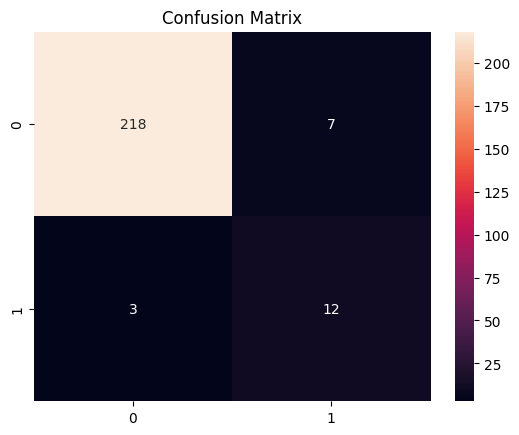

Model: SVC(C=10, random_state=42)
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       225
           1       0.63      0.80      0.71        15

    accuracy                           0.96       240
   macro avg       0.81      0.88      0.84       240
weighted avg       0.96      0.96      0.96       240

F1 score: 70.59%


In [216]:
model = "SVM"

print('-------------------------- Original dataset -----------------------------------')
print(f'Model: {model}')
print('-------------------------------------------------------------------------------')
X_train, X_test, y_train, y_test = preprocess(aux, drops, numerical_features, "Fail")
tmodel = train_model(X_train, y_train, model)
predict_and_evaluate(tmodel, X_test, y_test)

## Task 5

- Analyze variable importance.

- After developing a model, how can we determine which variables had the greatest impact on the
prediction?

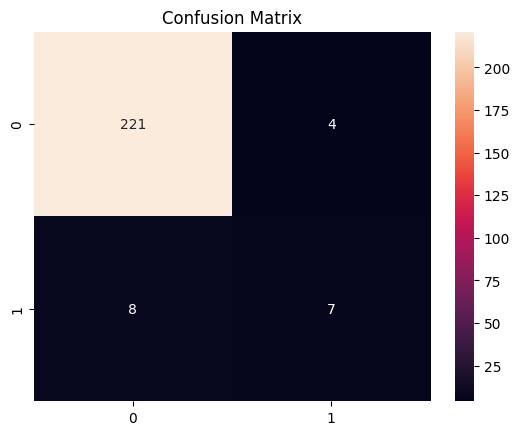

Model: RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=300,
                       random_state=42)
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       225
           1       0.64      0.47      0.54        15

    accuracy                           0.95       240
   macro avg       0.80      0.72      0.76       240
weighted avg       0.94      0.95      0.95       240

F1 score: 53.85%


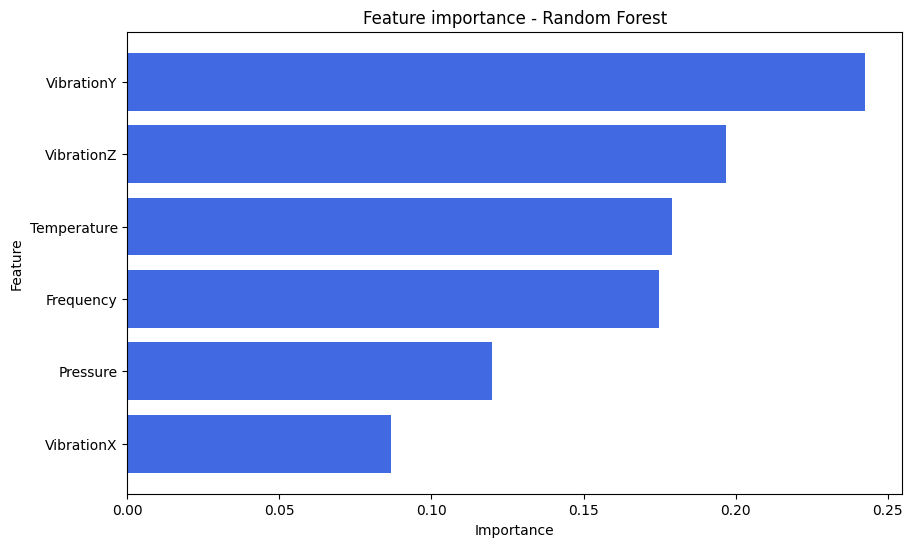

In [219]:
X_train, X_test, y_train, y_test = preprocess(aux, drops, numerical_features, "Fail")

tmodel = RandomForestClassifier(max_depth=10, min_samples_split=10, 
                                n_estimators=300, random_state=42)

tmodel.fit(X_train, y_train)

predict_and_evaluate(tmodel, X_test, y_test)

def plot_feature_importance(model, X_train):

    importances = model.feature_importances_

    feature_names = X_train.columns

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='royalblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature importance - Random Forest')
    plt.gca().invert_yaxis()
    plt.show()

plot_feature_importance(tmodel, X_train)
